# Dependencies

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
import networkx as nx
import netwulf as wulf
import datetime as dt
import shifterator as sh
import nltk
import re
import random
import json
import community

from wordcloud import WordCloud
from networkx.readwrite import json_graph
from collections.abc import Iterable
from collections import Counter
from scipy import stats
from tfidf import term_frequency, inverse_document_frequency, tf_idf
from typing import List

from data import get_master_dict

from IPython.display import clear_output

# Motivation
There are many courses taught at DTU. To keep track of it all, DTU has a database called 'the course base' found at https://kurser.dtu.dk/search where you are able to find some basic information about the courses. However, there is a lot more information about the courses than what can be found at the course base. In a previous project https://github.com/SMKIDRaadet/dtu-course-analyzer, students at DTU created a scraper that could gather additional information about the courses, such as average grade, course rating and gather it all in a dataset. For the purposes of this project, we came up with the idea to extend the scraper from the previous project to also collect the course 'description' which is simply the text from the tabs 'General course objectives', 'Learning objectives' and 'Content' on the course base. The text of the courses is tokenized and compiled in a corpus of documents, where each document corresponds to a course. We then posed some research questions that could be adressed using the dataset.  
**Main research questions:**
- Is there a correlation between the course topics and the average grade?
- To which degree is it possible to partition a network of courses into the existing departments at DTU using the course topics?  

To identify the course topics, we use TF-IDF to score terms in documents in the course corpus. Tonstruct the course network, we connect courses based on shared topics.  
In addition to the main analysis, we conduct some basic data exploration of the data, make wordclouds for the departments and more.

# Course data

## Load data
The course data is loaded into a pandas DataFrame. The row indices are course numbers. The most relevant columns are explained below:
- **name**: The course name.
- **department**: The department that offers the course.
- **description**: 'General course objectives' + 'Learning objectives' + 'Content' from the course page.
- **type** The course level: BSc, MSc, Ph.D etc.
- **ects** Number of points (ects) for the course.

In [2]:
courses = pd.DataFrame.from_dict(get_master_dict(), orient='index')

courses['ects'] = courses['ects'].str.replace(',', '.').astype(float)
courses['description'] = courses['description'].str.replace('\r\n', ' ')
courses['department'] = courses['department'].str.replace('\r\n', ' ')
courses['responsible'] = courses['responsible'].str.replace('\r\n', ' ')
courses['co-responsible'] = courses['co-responsible'].str.replace('\r\n', ' ')
courses['name'] = courses['name'].str.replace('\r\n', ' ')
courses['type'] = courses['type'].str.replace('Offered as a single course', '')
courses['department'] = courses.apply(lambda row: row['department'] if row['department'][0] != ' ' else row['department'][1:], axis=1)

courses.head()

,grades,name,passpercent,avg,pp,avgp,description,language,ects,type,location,evaluation,responsible,department,co-responsible,reviews,qualityscore,workload,lazyscore,prerequisites
62p02,"{'-3': '0', '00': '0', '02': '0', '4': '0', '7...",Communication and Team Relations,100.0,10.2,100.0,83.3,General course objectives The aim of the cour...,Danish,10.0,Deltidsdiplom,Copenhagen,"7 step scale , external examiner","Bjarke Nielsen , Ballerup Campus, Building Ba...",62 Department of Engineering Technology and Di...,NaN,NaN,NaN,NaN,NaN,NaN
42b88,{},Startup Boards,100.0,NaN,100.0,NaN,General course objectives This elective is ai...,English,1.0,Parttime master,Campus Lyngby,"pass / not pass , internal examiner","Hanne Søbæk Christiansen , Lyngby Campus, Bui...","42 Department of Technology, Management and Ec...","Stephane Guerraz (Primary contact person) , L...",NaN,NaN,NaN,NaN,NaN
28310,"{'-3': '0', '00': '0', '02': '0', '4': '11', '...",Chemical and Biochemical Product Design,98.0,8.8,96.6,68.8,General course objectives Chemical engineers ...,English,10.0,MSc,Campus Lyngby,"7 step scale , external examiner","Søren Kiil , Building 229, Ph. (+45) 4525 282...",28 Department of Chemical Engineering,Georgios Kontogeorgis (Primary contact person...,"[{'participants': 26, 'timestamp': 'E21', '1.1...",84.7,90.6,96.3,Bachelor degree You like to challange your tec...
42406,"{'-3': '0', '00': '0', '02': '0', '4': '0', '7...",Introduction to Production,100.0,9.7,100.0,78.1,General course objectives It is the object of...,Danish,5.0,BSc,Campus Lyngby,"7 step scale , external examiner","Lars Hvam , Lyngby Campus, Building 404 , lah...","42 Department of Technology, Management and Ec...",NaN,"[{'participants': 52, 'timestamp': 'E21', '1.1...",30.7,82.0,93.9,NaN
01034,"{'-3': '5', '00': '15', '02': '14', '4': '27',...",Advanced Engineering Mathematics 2,80.0,6.0,65.5,39.6,General course objectives To provide particip...,English,5.0,BSc,Campus Lyngby,"7 step scale , internal examiner","Poul G. Hjorth , Lyngby Campus, Building 303B...",01 Department of Applied Mathematics and Compu...,"David Brander , Lyngby Campus, Building 303B,...","[{'participants': 57, 'timestamp': 'E21', '1.1...",18.8,26.0,19.2,"01005/01006/01015/01016/(01901.­01920) , Advan..."


We also construct a dataframe grouped by department, where all descriptions are appended to each other.

In [3]:
departments = courses.groupby('department').agg({'description': 'sum', 'ects': 'mean', 'avg': 'mean'})
departments.head()

,description,ects,avg
department,,,
01 Department of Applied Mathematics and Computer Science,General course objectives To provide particip...,5.804878,7.973864
10 Department of Physics,General course objectives With mechanical phy...,6.300000,7.911628
11 Department of Civil Engineering,General course objectives The purpose of the ...,6.036585,7.234579
12 Department of Environmental Engineering,General course objectives To provide targeted...,5.937500,8.512121
22 Department of Health Technology,General course objectives The objective is to...,6.019737,8.716364


## Data summary
Here we show some summary statistics for the course dataset.

In [4]:
print(f"Summary of the course dataset:\n\nNumber of courses:\t\t\t{len(courses)}" + 
      f"\nDepartment offering most courses:\t{courses['department'].mode()[0]}" + 
      f"\nMost frequent teaching language:\t{courses['language'].mode()[0]}" +
      f"\nMost frequent course level:\t\t{courses['type'].mode()[0]}" + 
      f"\nAverage number of ECTS:\t\t\t{courses['ects'].mean():.2f}" + 
      f"\nAverage grade:\t\t\t\t{courses['avg'].mean():.2f}"
      f"\nAverage course description length:\t{courses.apply(lambda row: len(row['description']), axis=1).mean():.0f}")

Summary of the course dataset:

Number of courses:			1619
Department offering most courses:	62 Department of Engineering Technology and Didactics
Most frequent teaching language:	English
Most frequent course level:		MSc
Average number of ECTS:			5.99
Average grade:				8.14
Average course description length:	2042


## Data exploration
We can use the course data to explore a lot of interesting properties of the courses at DTU. Here we have shown some examples of some correlations, that we find interesting.

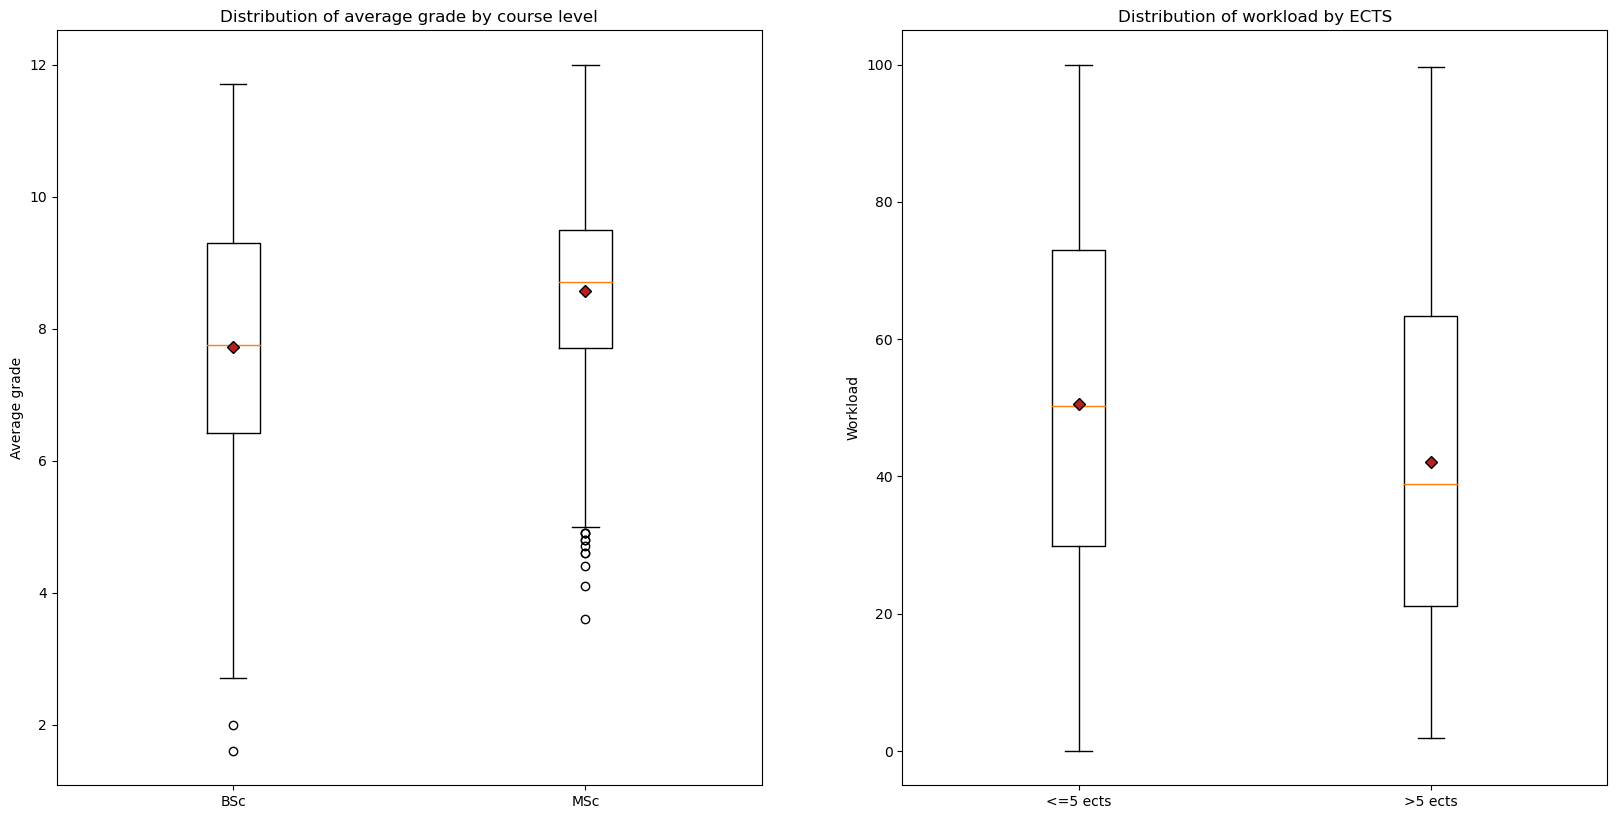

In [5]:
bsc_grades, msc_grades = courses['avg'][courses['type'] == 'BSc'].dropna(), courses['avg'][courses['type'] == 'MSc'].dropna()

meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=100)
ax1.boxplot((bsc_grades, msc_grades), showmeans=True, meanprops=meanpointprops)
ax1.set_xticklabels(('BSc', 'MSc'))
ax1.set_ylabel('Average grade')
ax1.set_title('Distribution of average grade by course level')

workloads = (courses['workload'][courses['ects'] <= 5].dropna(), courses['workload'][courses['ects'] > 5].dropna()) 

ax2.boxplot(workloads, showmeans=True, meanprops=meanpointprops)
ax2.set_xticklabels(('<=5 ects', '>5 ects'))
ax2.set_ylabel('Workload')
_ = ax2.set_title('Distribution of workload by ECTS')

# Corpus preprocessing

For the purposes of this analysis, the **text** of each course is cleaned and tokenized. The **text** of a course is the course **name** and the course **description**.

## Tokenizer

We tokenize the text by first removing all symbols and subsequently tokenizing the remaining words that at are not stop words.

In [6]:
# Stop words are removed from the tokenized text. We get the stop words here.
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words = stop_words.union(
    set(('versionsee', 'danish', 'general', 'course', 
         'learning', 'able', 'met', 'student', 'learning', 'objectives', 
         'content', 'dk', 'kurser', 'https', 'toolsapply', 'must', 'see', 
         'submit'))
)
stop_words = [re.sub('[^a-z_-]', '', stop_word) for stop_word in stop_words]

def tokenize(text: str) -> List[str]:
    """Tokenizer function. 
    The following is removed from the tokenized text:
    Symbols, stop words.
    """
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1 and 'void' not in word]
   
    return tokens

In [7]:
# The tokenized text is saved in a new column
departments['tokens'] = departments.apply(lambda row: tokenize(row['description']), axis=1)
courses['tokens'] = courses.apply(lambda row: tokenize(row['name'] + ' ' + row['description']), axis=1)
courses.head()

,grades,name,passpercent,avg,pp,avgp,description,language,ects,type,...,evaluation,responsible,department,co-responsible,reviews,qualityscore,workload,lazyscore,prerequisites,tokens
62p02,"{'-3': '0', '00': '0', '02': '0', '4': '0', '7...",Communication and Team Relations,100.0,10.2,100.0,83.3,General course objectives The aim of the cour...,Danish,10.0,Deltidsdiplom,...,"7 step scale , external examiner","Bjarke Nielsen , Ballerup Campus, Building Ba...",62 Department of Engineering Technology and Di...,NaN,NaN,NaN,NaN,NaN,NaN,"[communication, team, relations, aim, heighten..."
42b88,{},Startup Boards,100.0,NaN,100.0,NaN,General course objectives This elective is ai...,English,1.0,Parttime master,...,"pass / not pass , internal examiner","Hanne Søbæk Christiansen , Lyngby Campus, Bui...","42 Department of Technology, Management and Ec...","Stephane Guerraz (Primary contact person) , L...",NaN,NaN,NaN,NaN,NaN,"[startup, boards, elective, aiming, help, peop..."
28310,"{'-3': '0', '00': '0', '02': '0', '4': '11', '...",Chemical and Biochemical Product Design,98.0,8.8,96.6,68.8,General course objectives Chemical engineers ...,English,10.0,MSc,...,"7 step scale , external examiner","Søren Kiil , Building 229, Ph. (+45) 4525 282...",28 Department of Chemical Engineering,Georgios Kontogeorgis (Primary contact person...,"[{'participants': 26, 'timestamp': 'E21', '1.1...",84.7,90.6,96.3,Bachelor degree You like to challange your tec...,"[chemical, biochemical, product, design, chemi..."
42406,"{'-3': '0', '00': '0', '02': '0', '4': '0', '7...",Introduction to Production,100.0,9.7,100.0,78.1,General course objectives It is the object of...,Danish,5.0,BSc,...,"7 step scale , external examiner","Lars Hvam , Lyngby Campus, Building 404 , lah...","42 Department of Technology, Management and Ec...",NaN,"[{'participants': 52, 'timestamp': 'E21', '1.1...",30.7,82.0,93.9,NaN,"[introduction, production, object, give, stude..."
01034,"{'-3': '5', '00': '15', '02': '14', '4': '27',...",Advanced Engineering Mathematics 2,80.0,6.0,65.5,39.6,General course objectives To provide particip...,English,5.0,BSc,...,"7 step scale , internal examiner","Poul G. Hjorth , Lyngby Campus, Building 303B...",01 Department of Applied Mathematics and Compu...,"David Brander , Lyngby Campus, Building 303B,...","[{'participants': 57, 'timestamp': 'E21', '1.1...",18.8,26.0,19.2,"01005/01006/01015/01016/(01901.­01920) , Advan...","[advanced, engineering, mathematics, provide, ..."


# Text analysis

## Course corpus

We construct the course corpus by simply extracting the tokenized text for each course. Courses that have less than 30 tokens are omitted to filter out courses that do not have proper descriptions.

In [8]:
n_tokens = courses['tokens'].apply(lambda x: len(x))

# Create a corpus wich is a dictionary of the tokenized texts
corpus = courses['tokens'][n_tokens > 30].to_dict()

### Identifying course topics
TF-IDF can be used to score terms in a document in order of how descriptive they are of the document relative to the corpus. We use TF-IDF to sort the tokens in each course description by relevancy. Next, we take the all terms that are above the 94% percentile TF-IDF. We consider the percentile a hyperparameter that can be varied according to the analysis that is conducted.

In [9]:
# Get a lookup table for the idf of each term in the corpus.
idf_lookup = inverse_document_frequency(corpus)
print(f"Number of unique terms in the corpus: {len(idf_lookup)}")

Number of unique terms in the corpus: 13908


In [10]:
course_topics = {}
course_topics_tf = {}
for course, document in corpus.items():
    tfidf, terms, tf = tf_idf(document, idf_lookup, return_tf=True)
    
    mean, sd = tfidf.mean(), tfidf.std()
    topic_indices = tfidf >= np.percentile(tfidf, 94)
    topics = terms[topic_indices]
    topics_tf = tf[topic_indices]
    
    if topics.size:
        course_topics[course] = topics
        course_topics_tf[course] = {topics[i]: topics_tf[i] for i in range(topics.size)}

The percentile (94%) was calibrated based on some familiar courses. The calibration is done qualitatively, so we simply see if the identified topics make sense. Observe that the number of topics per course is not constant. This property is desirable compared to simply choosing the top $x$ terms.

In [11]:
calibration_courses = ('01005', '02467', '02456', '46500')

for course in calibration_courses:
    print(f'Course:\t{course}')
    print(f'Topics:\t{course_topics[course]}\n')

Course:	01005
Topics:	['mathematics' 'thematic' 'linear' 'equations' 'elementary' 'functions'
 'taylor' 'integrals']

Course:	02467
Topics:	['social' 'text' 'data' 'visualization' 'metrics' 'networks' 'communities'
 'exploration' 'plots']

Course:	02456
Topics:	['deep' 'machine' 'dl' 'neural' 'feed' 'forward' 'networks' 'back'
 'propagation' 'pytorch' 'ffnn']

Course:	46500
Topics:	['probabilistic' 'wind' 'data' 'structural' 'machine' 'measured' 'scada'
 'probability' 'calibrate' 'uncertainty' 'reliability' 'topic']



### Is there a correlation between the course topics and the passing grade?

We can use the scored topics to adress the first main research question.

In [12]:
# Get the topics and their avg grade.
topic_grades = {}

for course, topics in course_topics.items():
    # If the course does not have an avg grade, we skip it.
    course_avg_grade = courses.loc[course, 'avg']
    if np.isnan(course_avg_grade):
        continue
    
    for topic in topics:
        if topic not in topic_grades:
            topic_grades[topic] = [course_avg_grade]
        else:
            topic_grades[topic].append(course_avg_grade)

Let's look at some examples.

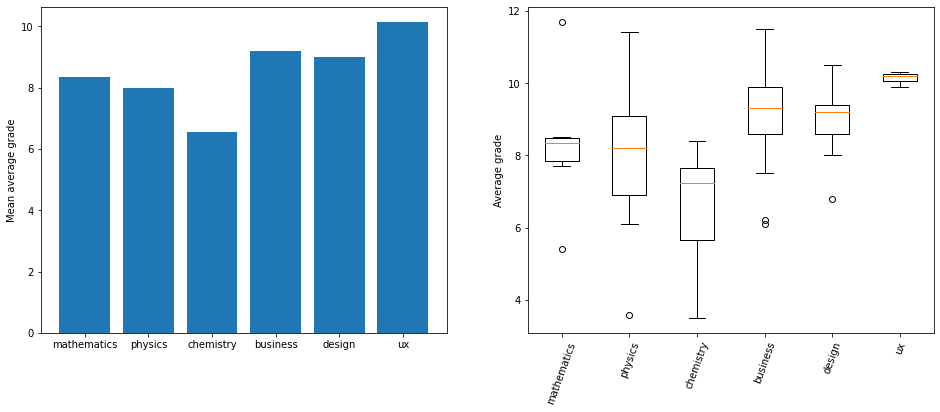

In [13]:
example_topics = ('mathematics', 'physics', 'chemistry', 'business', 'design', 'ux')
mean_avg_grades = [np.mean(topic_grades[topic]) for topic in example_topics]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(example_topics, [np.mean(topic_grades[topic]) for topic in example_topics])
plt.xticks(rotation=70)
_ = ax1.set_ylabel('Mean average grade')

ax2.boxplot([topic_grades[topic] for topic in example_topics])
ax2.set_xticklabels(example_topics, rotation=70)
_ = ax2.set_ylabel('Average grade')

There seems to be a difference in average grade between courses, that have certain topics in their curriculum.

Let's plot the distributions of the average grades for the main topics taught at DTU. To identify the main topics the topics that appear in less than 8 courses are filtered out.

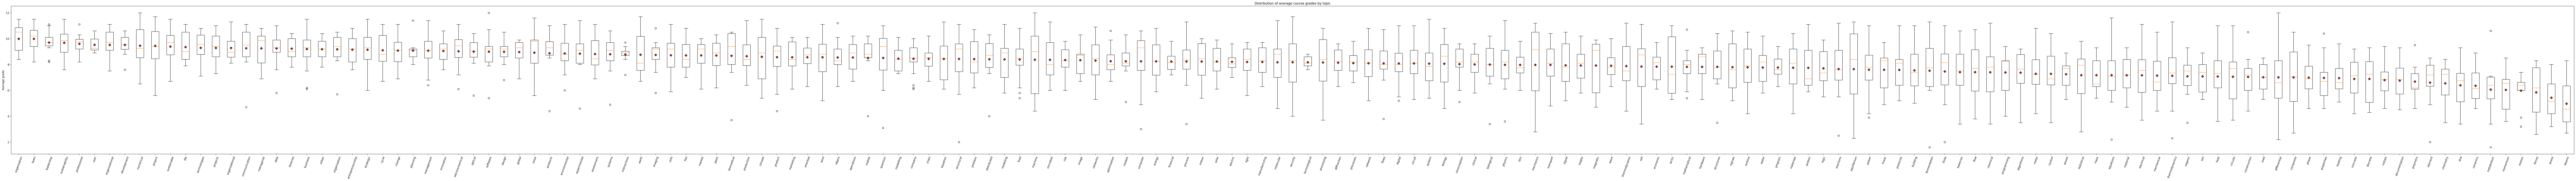

In [14]:
# Filter topics that occur in less than 8 courses
min_appearances = 8

topic_grades_filtered = {topic: avg_grades for topic, avg_grades in topic_grades.items() if len(avg_grades) >= min_appearances}
topic_arr = np.array(list(topic_grades_filtered.keys()))
topic_avg_grades = list(topic_grades_filtered.values())
topic_mean_avg_grades = np.array([np.mean(avg_grades) for avg_grades in topic_avg_grades])
sorted_indices = np.argsort(topic_mean_avg_grades)[::-1]

topic_arr = topic_arr[sorted_indices]
topic_avg_grades = [topic_avg_grades[index] for index in sorted_indices]
topic_mean_avg_grades = topic_mean_avg_grades[sorted_indices]

meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')

fig, ax = plt.subplots(1, 1, figsize=(topic_arr.size * 1, 10), dpi=200)

ax.boxplot(topic_avg_grades, showmeans=True, meanprops=meanpointprops)
ax.set_xticklabels(topic_arr, rotation=70)
ax.set_ylabel('Average grade')
_ = ax.set_title('Distribution of average course grades by topic')
plt.savefig('grades_by_topic')

Once again, we observe that there is a difference in the average grade distribution depending on the topic taught in the course. However, we won't investigate whether there isa  significant difference between the average grade for one topic versus another as that would require a statistical test. We leave any such statistical tests to the reader or future analysis.

## Department corpus
We can also make a corpus of all course descriptions in a department. We can use TF-IDF to score the terms and create some very nice looking wordclouds, that visualize the terms that are most relevant for each department.

### Wordclouds

In [15]:
# Create a corpus wich is a dictionary of the tokenized texts
corpus = departments['tokens'].to_dict()
idf_lookup = inverse_document_frequency(corpus)

# # Generate a word cloud image
# for department, document in corpus.items():
#     tfidf, terms = tf_idf(document, idf_lookup)
#     wc = WordCloud(background_color='white', width=1600, height=800).generate_from_frequencies({term: w for w, term in zip(tfidf, terms)})
    
#     fig, ax = plt.subplots(1, 1, figsize=(18, 9))
#     fig.suptitle(f'{department}', fontsize='xx-large')
#     ax.imshow(wc, interpolation='bilinear')
#     ax.axis('off')
#     plt.show()

# Network analysis
In this section, we create a network of courses using the previously identified course topics and analyse the properties of the network.

## Constructing the network
In this section, we create a network of courses. The nodes in the network are courses. The edges are created in the following way:
For every node (course) loop over all other courses, and if the courses share any topics, create an edge. The weight of the edge is determined by the term frequencies of the topics that the nodes share. Suppose that course 1 and course 2 share topics $a$, $b$ and $c$ and let $TF(topic, course)$ denote the term frequency of $topic$ in the text of $course$. Then the weight of the edge between course 1 and course 2 is given by:
\begin{align*}
    w(1, 2) = TF(a, 1) \cdot TF(a, 2) + TF(b, 1) \cdot TF(b, 2) + TF(c, 1) \cdot TF(c, 2)
\end{align*}

In [16]:
# If you have a previously saved graph and don't want to run the graph creation code below, set new_graph to False
new_graph = False

if new_graph:
    adjacency_dict = {}

    n_courses = len(course_topics)
    for i, (course, topics) in enumerate(course_topics.items()):
        edges = {}

        topics_set = set(topics)
        for other_course, other_topics in course_topics.items():
            if course == other_course:
                continue

            common_topics = topics_set.intersection(other_topics)
            if len(common_topics) > 0:
                w = sum([course_topics_tf[course][topic] * course_topics_tf[other_course][topic] for topic in common_topics])

                edges[other_course] = {'weight': float(w)}

        adjacency_dict[course] = edges

        clear_output(wait=True)
        print(i/n_courses)

    G = nx.Graph(adjacency_dict)

    with open('course_graph.json', 'w') as outfile:
        json.dump(json_graph.node_link_data(G), outfile, indent=8)
else:
    with open('course_graph.json') as f:
        G = json_graph.node_link_graph(json.load(f))

### Basic network properties
Here we show some summary statistics for the network.

Summary of the course network:

Number of nodes:	1579
Number of edges:	30690
Average node degree:	38.87


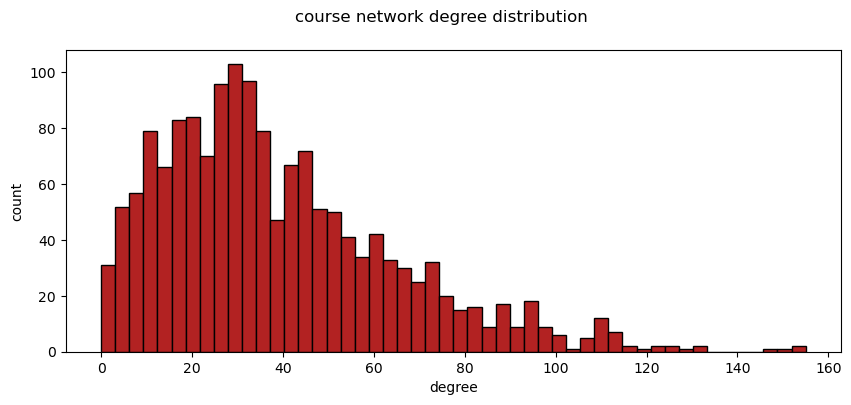

In [17]:
degrees = list(dict(G.degree).values())
avg_degree = np.mean(degrees)

print(f'Summary of the course network:\n\nNumber of nodes:\t{G.number_of_nodes()}' + 
      f'\nNumber of edges:\t{G.number_of_edges()}\nAverage node degree:\t{avg_degree:.2f}')


fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=100)

fig.suptitle('course network degree distribution')

ax.hist(degrees, bins=50, color='firebrick', edgecolor='k')

ax.set_xlabel('degree')
ax.set_ylabel('count')
plt.show()

## Network visualization
We visualize the network to get an idea of the structure of the network. The nodes are colored by department.

In [18]:
n_departments = courses['department'].nunique()

cm = plt.get_cmap('tab20b')
color_linspace = np.linspace(0, 1, num=n_departments)
department_cmap = {department: tuple((np.array(cm(color_linspace[i]))[:3] * 255).astype(int)) for i, department in enumerate(courses['department'].unique())}
department_cmap = {department: (rgb, "#{0:02x}{1:02x}{2:02x}".format(*rgb)) for department, rgb in department_cmap.items()}

for k, v in G.nodes(data=True):
    v['group'] = department_cmap[courses.loc[k, 'department']][1]

In [19]:
config = {'zoom': 0.75,
 'node_charge': -45,
 'node_gravity': 0.13253538995726497,
 'link_distance': 50,
 'link_distance_variation': 0,
 'node_collision': True,
 'wiggle_nodes': False,
 'freeze_nodes': False,
 'node_fill_color': '#79aaa0',
 'node_stroke_color': '#373737',
 'node_label_color': '#000000',
 'display_node_labels': False,
 'scale_node_size_by_strength': True,
 'node_size': 10.729333600427351,
 'node_stroke_width': 1,
 'node_size_variation': 0.3155548878205128,
 'link_color': '#575656',
 'link_width': 0.7037790798611111,
 'link_alpha': 0.49720775462962963,
 'link_width_variation': 0.39760616987179487,
 'display_singleton_nodes': True,
 'min_link_weight_percentile': 0,
 'max_link_weight_percentile': 1}

stylized_network, config = wulf.visualize(G, config=config, is_test=False, plot_in_cell_below=False)

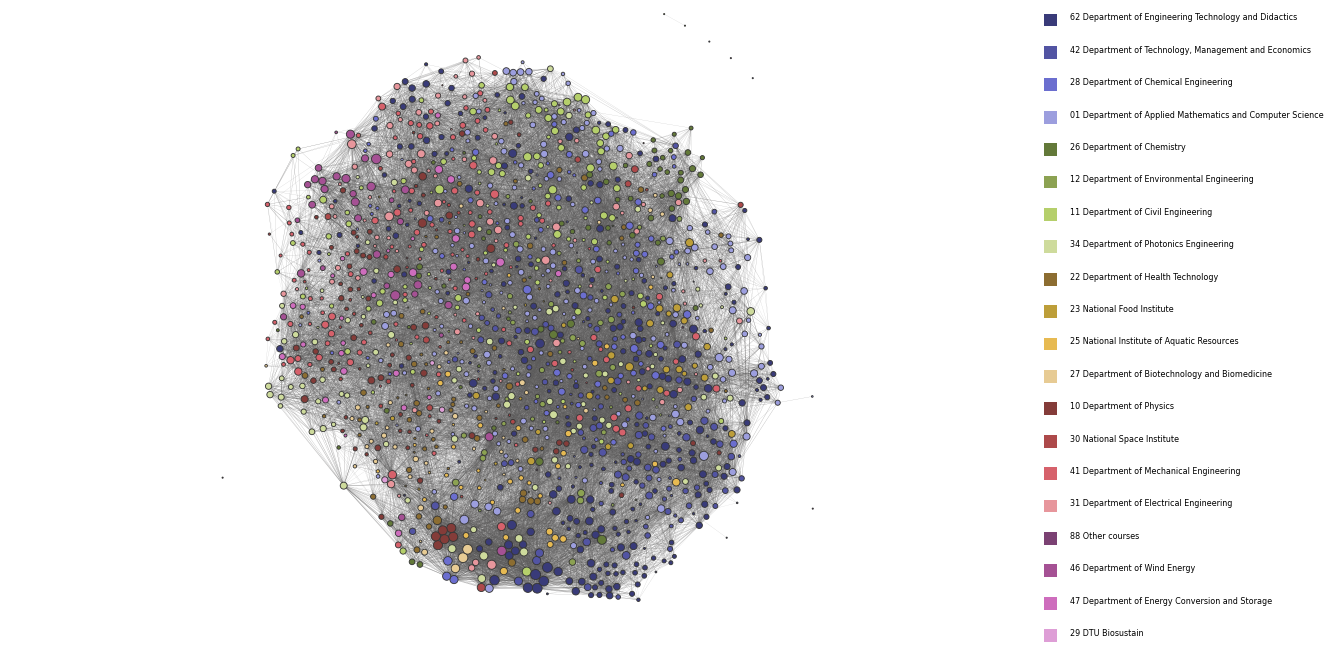

In [20]:
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(18, 9)
subfig1, subfig2 = fig.subfigures(1, 2, wspace=0, width_ratios=(.8, .2))
axs = subfig2.subplots(n_departments, 2)

for i, (department, (rgb, _)) in enumerate(department_cmap.items()):
    ax_color, ax_text = axs[i]
    ax_text.text(0, 0.5, department, dict(size=8))
    ax_color.imshow([[np.array(rgb)/255]])
    ax_text.axis('off')
    ax_color.axis('off')

ax = subfig1.subplots(1, 1)
fig, ax = wulf.draw_netwulf(stylized_network, fig=subfig1, ax=ax)
plt.show()

We observe clustering and partitioning of the graph, but departments seem be fairly intertwined in some areas.

## Analysis of modularity
To analyse the topic connected network, we can calculate the modularity of the network based on the department partition. If the observed modularity is high, it means that the courses (nodes) within each department is highly connected and courses from different departments are sparsely connected. We will use the modularity to determine the quality of the network in terms of partitioning the departments. We will also compare the modularity of our network with a network where the edges are shuffled.

In [21]:
department_partition = {}
for k, v in G.nodes(data=True):
    department = courses.loc[k, 'department']
    if department not in department_partition:
        department_partition[department] = set([k])
    else:
        department_partition[department].add(k)
department_partition = list(department_partition.values())

modularity = nx.algorithms.community.modularity(G, department_partition)

RG = G.copy()
RG = nx.double_edge_swap(RG, nswap=1000, max_tries=10000)

department_partition = {}
for k, v in RG.nodes(data=True):
    department = courses.loc[k, 'department']
    if department not in department_partition:
        department_partition[department] = set([k])
    else:
        department_partition[department].add(k)
department_partition = list(department_partition.values())

modularity_random = nx.algorithms.community.modularity(RG, department_partition)

print(f'Modularity of the graph:\t\t{modularity}\nModularity of the shuffled graph:\t{modularity_random}')

Modularity of the graph:		0.23841905811719705
Modularity of the shuffled graph:	0.0102740466063179


We observe that modularity of our graph is relatively low but is much higher than the shuffled graph. The low modularity could be explained by the fact that the departments at DTU share a lot of topics. For instance, the department of chemistry and the department of chemical engineering share a lot of topics and could perhaps be considered interchangeable.

## Community detection
Instead of using the departments directly as a partition, we can compute a network partition of our own, which maximizes the modularity of our network. To this end, we use the Louvain algorithm.

In [22]:
partition = nx.algorithms.community.louvain_communities(G, resolution=1, threshold=1e-07, seed=1510)

Since that there are some parts of the network that are disconnected from the main graph, we collect all communities with less than or equal to 5 members into one communtity.

In [23]:
cleaned_partition = []
other_community = set()
for community in partition:
    if len(community) > 5:
        cleaned_partition.append(community)
    else:
        other_community = other_community.union(community)

cleaned_partition.append(other_community)
partition = cleaned_partition

### Louvain communities visualization
Here we show the network where the nodes are coloured by their community as identified by the Louvain algorithm.

In [24]:
n_communities = len(partition)

cm = plt.get_cmap('tab20b')
color_linspace = np.linspace(0, 1, num=n_communities)
community_cmap = {i: tuple((np.array(cm(color_linspace[i]))[:3] * 255).astype(int)) for i in range(n_communities)}
community_cmap = {i: (rgb, "#{0:02x}{1:02x}{2:02x}".format(*rgb)) for i, rgb in community_cmap.items()}

for k, v in G.nodes(data=True):
    for i, community in enumerate(partition):
        if k in community:
            break
    v['group'] = community_cmap[i][1]

In [25]:
stylized_network, config = wulf.visualize(G, config=config, is_test=False, plot_in_cell_below=False)

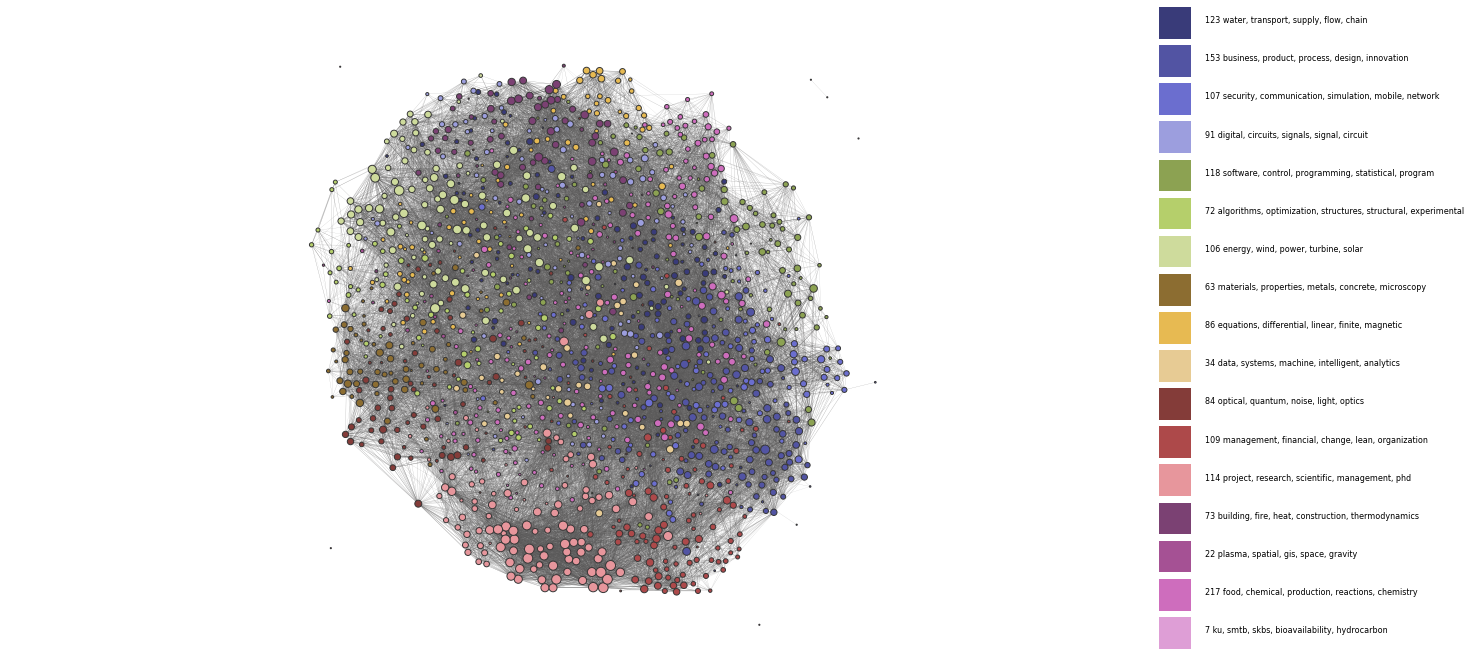

In [26]:
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(20, 9)
subfig1, subfig2 = fig.subfigures(1, 2, wspace=0, width_ratios=(.8, .2))
axs = subfig2.subplots(n_communities, 2)

for i, (rgb, _) in community_cmap.items():
    community = partition[i]
    community_topic_counts = {}
    for course in community:
        for topic, tf in course_topics_tf[course].items():
            if topic not in community_topic_counts:
                community_topic_counts[topic] = tf
            else:
                community_topic_counts[topic] += tf
    topics, counts = np.array(list(community_topic_counts.keys())), np.array(list(community_topic_counts.values()))
    if topics.size:
        sorted_indices = np.argsort(counts)[::-1]
        topics_top5 = list(topics[sorted_indices[:5]])
    ax_color, ax_text = axs[i]
    ax_text.text(0, 0.5, f"{len(community)} {', '.join(topics_top5)}" , dict(size=8))
    ax_color.imshow([[np.array(rgb)/255]])
    ax_text.axis('off')
    ax_color.axis('off')

ax = subfig1.subplots(1, 1)
fig, ax = wulf.draw_netwulf(stylized_network, fig=subfig2, ax=ax)
plt.show()

### To which degree is it possible to partition a network of courses into the existing departments at DTU using the course topics? (Jaccard similarity)
Finally, we compute the Jaccard similiarity between the partition that was computed using the Louvain algorithm and the partition based on departments. The Jaccard similiarity is a metric between $0$ and $100$% that measures the similarity between two different partitions of a set of elements.

In [27]:
department2label = {department: index for index, department in enumerate(courses['department'].unique())}

In [28]:
Z = []
Q = []
for index, community in enumerate(partition):
    for course in community:
        Z.append(index)
        Q.append(department2label[courses.loc[course, 'department']])
Z = np.array(Z)
Q = np.array(Q)

N = Z.size
K, M = max(Z) + 1, max(Q) + 1

# Joint count matrix
nkm = np.zeros((max(Z) + 1, max(Q) + 1))
for z in range(K):
    for q in range(M):
        nkm[z, q] = np.sum((Z == z) & (Q == q))
nZ = nkm.sum(1)
nQ = nkm.sum(0)

In [29]:
S = np.sum(nkm * (nkm - 1) / 2)
D = N * (N - 1) / 2 - np.sum(nZ * (nZ - 1) / 2) - np.sum(nQ * (nQ - 1) / 2) + S
J = S / (.5 * N * (N - 1) - D)

print(f'Jaccard similarity between Louvain partition and department partition:\t{100 * J:.2f}%')

Jaccard similarity between Louvain partition and department partition:	8.46%


It seems that the two partitions are not very similar. However, we postulate that our partitioning of the courses at DTU are slightly better at explaining which courses one can expect within the groups, so perhaps it is time for a new department structure... or something ;)

### Save graph attributes for visualization
(Not a part of the analysis)

In [30]:
nodes, links = [], []
course_ids = {}
department_ids = {department: i for i, department in enumerate(courses['department'].unique())}
partition_ids = {course: i for i, community in enumerate(partition) for course in community}
partition_names = {}

for i, community in enumerate(partition):
    community_topic_counts = {}
    for course in community:
        for topic, tf in course_topics_tf[course].items():
            if topic not in community_topic_counts:
                community_topic_counts[topic] = tf
            else:
                community_topic_counts[topic] += tf
    topics, counts = np.array(list(community_topic_counts.keys())), np.array(list(community_topic_counts.values()))
    if topics.size:
        sorted_indices = np.argsort(counts)[::-1]
        topics_top5 = list(topics[sorted_indices[:5]])
    name = ', '.join(topics_top5[:-1]) + ' and ' + topics_top5[-1]
    name = name[0].upper() + name[1:]
    partition_names[i] = name

for index, (course, val) in enumerate(G.nodes(data=True)):
    course_ids[course] = index
    department_name = courses.loc[course, 'department']
    partition_id = partition_ids[course]
    node = {
        'id': index,
        'name': course,
        'label': courses.loc[course, 'name'],
        'department_id': department_ids[department],
        'partition_id': partition_id,
        'department_name': department_name,
        'partition_name': partition_names[partition_id]
    }
    nodes.append(node)

for source, target, attr in G.edges(data=True):
    weight = attr['weight']
    words = list(set(course_topics[source]).intersection(course_topics[target]))
    link = {
        'source': course_ids[source],
        'target': course_ids[target],
        'weight': weight,
        'words': words
    }
    links.append(link)

graph_dict = {'nodes': nodes, 'links': links}
graph_dict

{'nodes': [{'id': 0,
   'name': '34318',
   'label': 'Programming projects for Cyber Technology',
   'department_id': 12,
   'partition_id': 4,
   'department_name': '34 Department of Photonics Engineering',
   'partition_name': 'Software, control, programming, statistical and program'},
  {'id': 1,
   'name': '62247',
   'label': 'Spanish - in an international context',
   'department_id': 12,
   'partition_id': 1,
   'department_name': '62 Department of Engineering Technology and Didactics',
   'partition_name': 'Business, product, process, design and innovation'},
  {'id': 2,
   'name': '41126',
   'label': 'Fluvial and marine sediment transport',
   'department_id': 12,
   'partition_id': 0,
   'department_name': '41 Department of Mechanical Engineering',
   'partition_name': 'Water, transport, supply, flow and chain'},
  {'id': 3,
   'name': '34127',
   'label': 'Experimental optics and photonics',
   'department_id': 12,
   'partition_id': 10,
   'department_name': '34 Department